In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.plotly as py
from scipy import stats
import seaborn as sns
import cufflinks as cf
from ipywidgets import interact
import plotly.tools as tls
from scipy.cluster.hierarchy import dendrogram, linkage
cf.go_offline()
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.formula.api as smf
import researchpy as rp

In [2]:
df=pd.read_csv('../train.csv')
df.shape

(1460, 81)

# PART 1: Explore data and understand what the fields mean. Descriptive statistics 

## Part 1.1 There are 6965  rows with Nan value. Cleaning

Dropped all the columns, where the exist ANY NaN value:
'Alley','MasVnrType','MasVnrArea', 'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1','Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual','GarageCond', 'PoolQC','Fence', 'MiscFeature'.

Total 19 dropped in the dataframe : 62 remained out of 81 columns.
Normally, I had to "Remove columns with high proportion of missing values." But due to reduced time, I don't dare to explore those columns yet. Maybe sometimes later. There are still 62 columns to explore and to use.

I also, played with df.dropna(thresh=2), thresh was set from 80 to 70, then decreasing to 70. Row number of 1460 remained unchanged - maybe a bug

In [4]:
df=df.dropna(axis=1, how='any')

In [6]:
df.isnull().sum().sum()# Check that now the table contains 0 NaN value

0

## Part 1.2 - Explore "SalePrice" Column

In [7]:
df.SalePrice.describe() 

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

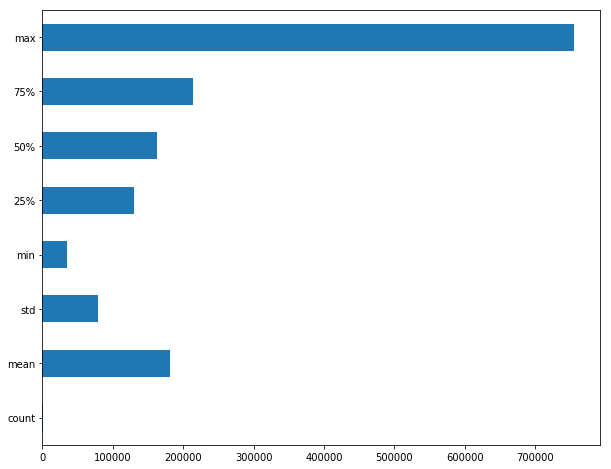

In [8]:
df.SalePrice.describe().plot.barh(figsize=(10,8))

## Part 1.3 - Look on all the numeric columns

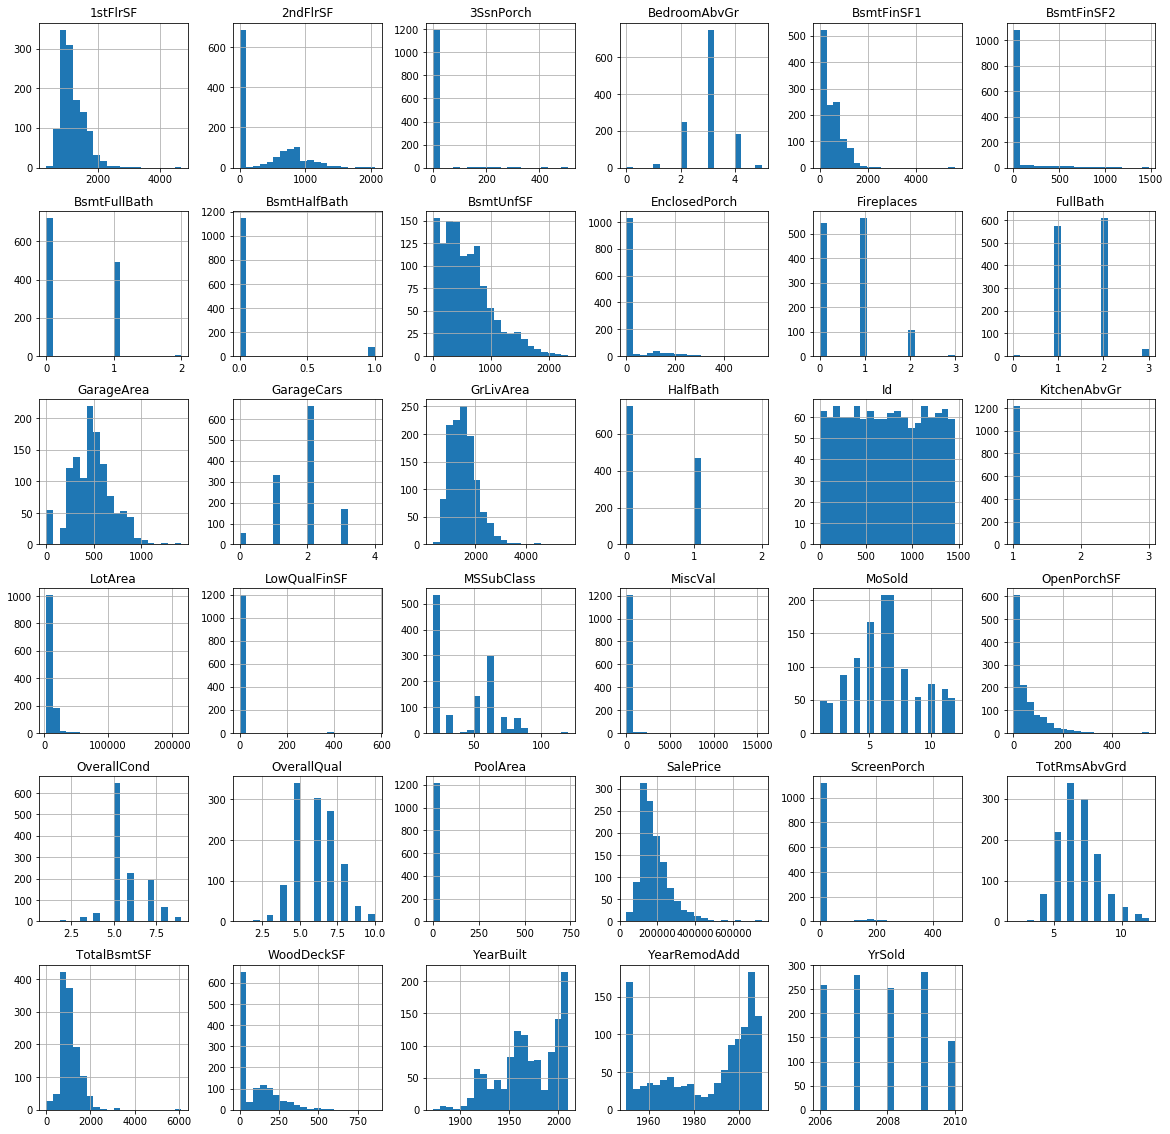

In [46]:
df.hist(bins=20, figsize=(20,20))
plt.show()
# Part 1.3 Have a visual support to understand other columns for my further exploratory analysis

In [172]:
# 2D: Pair-Wise Scatter Plots - to investigate. sns.pairplot later

## Part 1. 4 - Visual representation of 'Building Type' column. 

In [10]:
df.BldgType.value_counts()
# Part 1. 4 - Visual representation of Building Type column. Out of 1460 rows there are:

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

In [11]:
sizes=df.BldgType.value_counts()
labels = ['Single-family Detached', 'Townhouse End Unit', 'Duplex', 'Townhouse Inside Unit', 'Two-family Conversion']

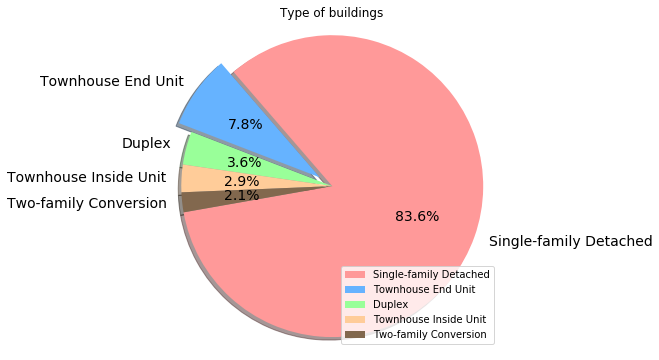

In [12]:
explode = (0, 0.1, 0,0,0)
fig1, ax1 = plt.subplots(figsize=[6, 6])
plt.title('Type of buildings')
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#82684E']
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=190, colors=colors, explode=explode, textprops={'fontsize': 14})
ax1.axis('equal')

plt.legend(labels,loc=4)
plt.show()

### Part 1.4 - Conclusion: 83.6 % of Data concerns "Single-Family Detached" type of buildings. 
## Well, lets reduce the scope and explore further the data which is > 80% of entire Dataset

In [13]:
df=df[df['BldgType']=='1Fam']
df.shape
# There 1220 rows (83.6 %) Single Family Detached buildings sold.
# the dataframe now contains only this type of buildings.

(1220, 62)

'''
Checking the SalePrice in the original dataframe before filtering to 1 type of buildings. 

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
  
  
  to the dataframe with single family buildings only :
count    1220.000000  
mean     185763.807377
std      82648.502922 
min      34900.000000 
25%      131475.000000
50%      167900.000000
75%      222000.000000
max      755000.000000
Name: SalePrice, dtype: float64

mean Before= 180921.19 vs After Filtering = 185763.80. Delta is 4842.61. Which is 2.7 % increase of the mean value,
while 16.4 % of data dropped off.

'''

## Part 1.5 - MSZoning column exploration. How the price of the Sales depends on the classification of the zone

MSZoning: Identifies the general zoning classification of the sale.
       C	Commercial.
       FV	Floating Village Residential. 
       RH	Residential High Density.
       RL	Residential Low Density.
       RM	Residential Medium Density.

In [49]:
ZonesTable=df.groupby('MSZoning', as_index=True)['SalePrice'].agg(Minimum=np.min, Maximum=np.max, Average=np.mean).sort_values(by='Average')

In [52]:
ZonesTable

,Minimum,Maximum,Average
MSZoning,,,
C (all),34900,108000,67931.111111
RH,76000,159434,110770.444444
RM,37900,475000,125436.899281
RL,39300,755000,193592.266341
FV,176000,370878,240940.236842


In [16]:
ZonesTable.iplot(kind='bar', xTitle='Zoning Classification', yTitle='Sale Price', 
           title='Minimum, Maximum and Average Prices by Zone Classification', filename='bar-direct-labels')

The highest minimum and average is noticed in FV Floating Village Residential, as well as in the "
RL Residential Low Density".  SalePrice in C Commercial classified zones are lowest.

## Part 1.6 - Neighborhood

In [17]:
df.groupby('Neighborhood')['MSZoning'].value_counts()

Neighborhood  MSZoning
Blmngtn       RL            1
BrkSide       RM           30
              RL           26
ClearCr       RL           28
CollgCr       RL          140
Crawfor       RL           45
Edwards       RL           78
              RH            2
              RM            1
Gilbert       RL           78
IDOTRR        RM           25
              C (all)       9
Mitchel       RL           36
NAmes         RL          205
NWAmes        RL           71
NoRidge       RL           41
NridgHt       RL           55
OldTown       RM           83
              RL           13
SWISU         RL           19
              RH            3
Sawyer        RL           67
SawyerW       RL           43
              RH            4
Somerst       FV           38
              RL           21
StoneBr       RL           13
Timber        RL           37
Veenker       RL            8
Name: MSZoning, dtype: int64

In [18]:
NeighbTable=df.groupby('Neighborhood', as_index=True)['SalePrice'].agg(Minimum=np.min, Maximum=np.max, Average=np.mean).sort_values(by='Average')

In [19]:
NeighbTable.iplot(kind='bar', xTitle='Neighborhood Impact', yTitle='Sale Price', 
           title='Minimum, Maximum and Average Prices by Neighborhood', filename='bar-direct-labels')

Chic neighborhood noticed to be Somerst=Somerset with FV=38 and RL=21 dwellings sold at higher average prices.
StoneBr = Stone Brook is classified as RL zone with only 13 dwellings sold, but with the highest average price.
NridgHt =Northridge Heights= RL with 55 is Number 2.

## Part 1.7 - Overall Condition

There majority of sells are in conditions 5 - Average and 6 - Above Average.
OverallCond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor

Text(0, 0.5, 'Count')

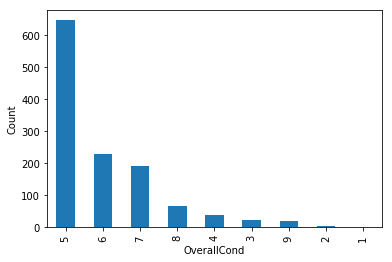

In [20]:
df['OverallCond'].value_counts().plot(kind='bar')
plt.xlabel('OverallCond')
plt.ylabel('Count')

In [21]:
OverallCondition=df.groupby('OverallCond', as_index=True)['SalePrice'].agg(Minimum=np.min, Maximum=np.max, Average=np.mean)

In [22]:
OverallCondition.iplot(kind='bar', xTitle='OverallCondition Impact', yTitle='Sale Price', 
           title='Minimum, Maximum and Average Prices by OverallCondition', filename='bar-direct-labels')

#### Strangely the dwellings rated at 5 and 6 position - have the Maximum higher than 7-9?


## Part 1.8 - Year of transaction and Prices

In [23]:
YrSold=df.groupby('YrSold', as_index=True)['SalePrice'].agg(Minimum=np.min, Maximum=np.max, Average=np.mean)

In [186]:
YrSold.head()

,Minimum,Maximum,Average
YrSold,,,
2006,35311,625000,188694.356589
2007,39300,755000,190527.892857
2008,40000,446261,178139.296443
2009,34900,582933,185613.482517
2010,55993,611657,184938.412587


In [24]:
YrSold.iplot(kind='bar', xTitle='YrSold', yTitle='SalePrice')

## Part 1.9 - Lot size and the price correspondingly

### Vizualized the most common lot size and the prices
##### LotArea: Lot size in square feet. 

In [25]:
df_tronque=df[(df.SalePrice < df.SalePrice.quantile(0.90)) & (df.SalePrice > df.SalePrice.quantile(0.10))& (df.LotArea < df.LotArea.quantile(0.8) )]
df_tronque.SalePrice.describe()

count       796.000000
mean     169711.443467
std       43668.483094
min      108480.000000
25%      134875.000000
50%      160500.000000
75%      195000.000000
max      287000.000000
Name: SalePrice, dtype: float64

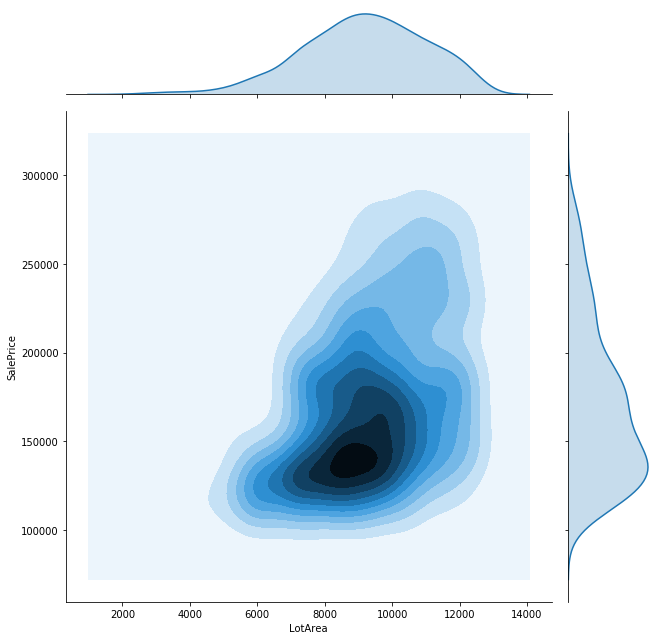

In [26]:
sns.jointplot(x='LotArea', y='SalePrice', data=df_tronque, kind="kde", height=9)

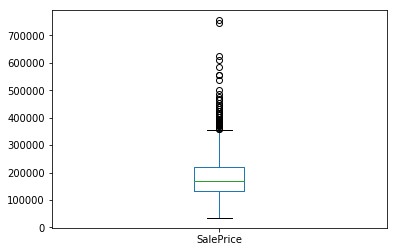

In [40]:
#fig, (ax1, ax2)=plt.subplots(1,2, figsize=(20,6))

df.SalePrice.plot.box()
#df_tronque.SalePrice.plot.box()

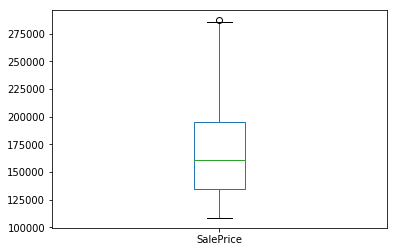

In [39]:
df_tronque.SalePrice.plot.box()

##### Most commonly sold sizes are between 7000 and 11000 square feet with the prices in 125k to 200k.

## Part 1.10 - Base parameters

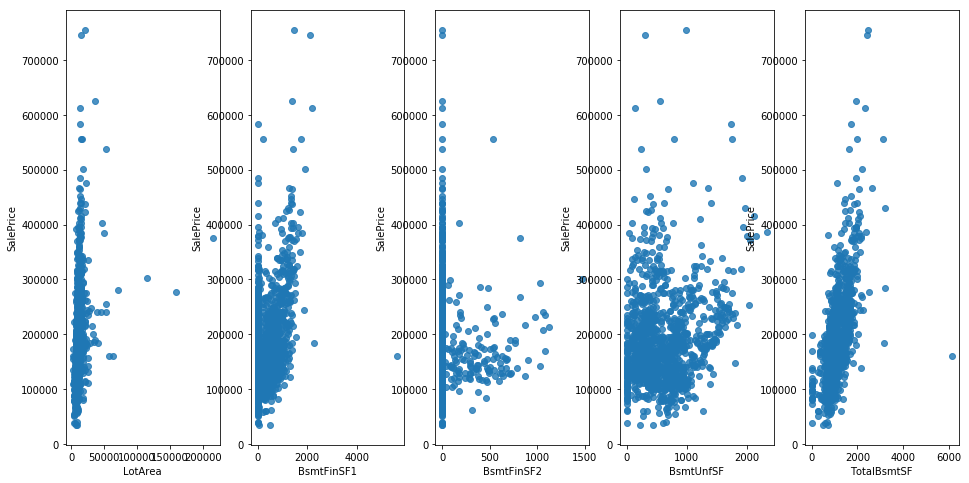

In [43]:
cols=['LotArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', 'SalePrice']
to=df[cols]
fig,axes = plt.subplots(figsize = (16,8), nrows = 1, ncols = 5)
for i in range(5):
    plt.sca(axes[i])
    plt.scatter(to.iloc[:,i],to['SalePrice'], alpha = 0.8)
    plt.xlabel(to.iloc[:,i].name)
    plt.ylabel('SalePrice')

## Part 1.11 - MSSubClass

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER


In [125]:
MSSubClass_table=df.pivot_table(index='MSSubClass', aggfunc='mean')

In [126]:
Z=linkage(MSSubClass_table, 'ward')

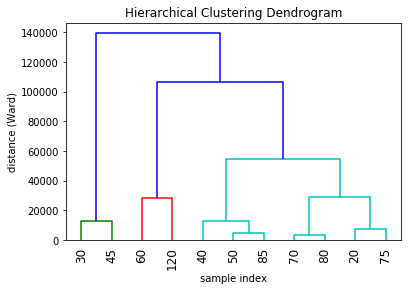

In [127]:
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')
dendrogram(Z, labels=MSSubClass_table.index, leaf_rotation=90)
plt.show()

A numeric matrix where several variables describe the features of individuals.
We can then calculate the distance between individuals and clustering them

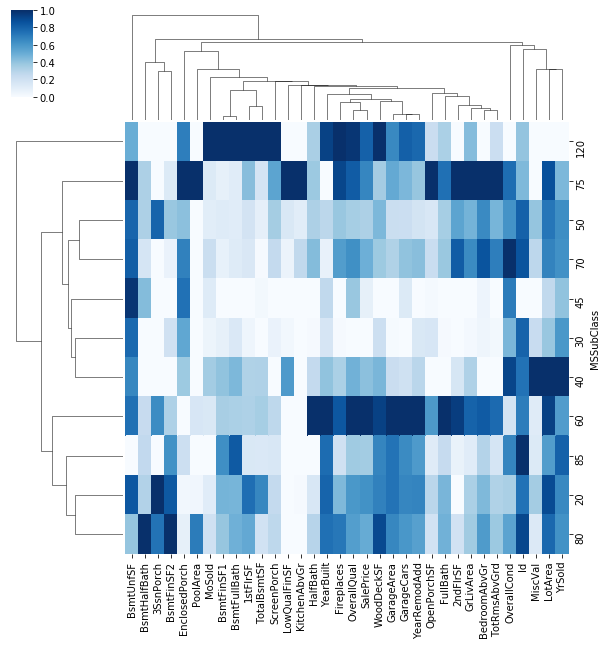

In [128]:
sns.clustermap(MSSubClass_table, metric="correlation", method="single", cmap="Blues", standard_scale=1)

In [129]:
new=MSSubClass_table.drop(columns=[ 'MiscVal', 'MoSold','YearBuilt', 'YearRemodAdd', 'YrSold', '1stFlrSF', '2ndFlrSF', '3SsnPorch', 'EnclosedPorch', 'Fireplaces', 'Id', 'ScreenPorch', 'WoodDeckSF', 'GarageArea', 'GarageCars'])

In [130]:
new.columns

Index(['BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath',
       'BsmtHalfBath', 'BsmtUnfSF', 'FullBath', 'GrLivArea', 'HalfBath',
       'KitchenAbvGr', 'LotArea', 'LowQualFinSF', 'OpenPorchSF', 'OverallCond',
       'OverallQual', 'PoolArea', 'SalePrice', 'TotRmsAbvGrd', 'TotalBsmtSF'],
      dtype='object')

In [131]:
Z=linkage(new, 'ward')

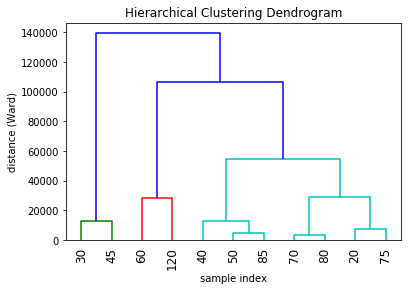

In [132]:
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')
dendrogram(Z, labels=MSSubClass_table.index, leaf_rotation=90)
plt.show()

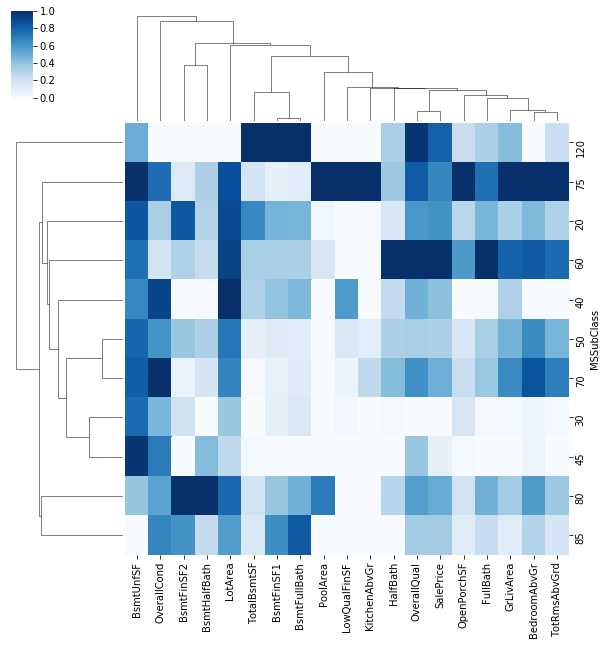

In [133]:
sns.clustermap(new, metric="correlation", method="single", cmap="Blues", standard_scale=1)

Strong correlation:

LotArea for categories from 40 to 75
Cat 75(  2-1/2 STORY ALL AGES )- LowQualFinSF: Low quality finished square feet (all floors), KitchenAbvGr: Kitchens above grade, Pool Area
Cat 60 - SalePrice, Overall Quality, HalfBath
Cat 40 - Lot Area: Lot size in square feet


## Part 1.12 - Year of construction vs years of re modelling

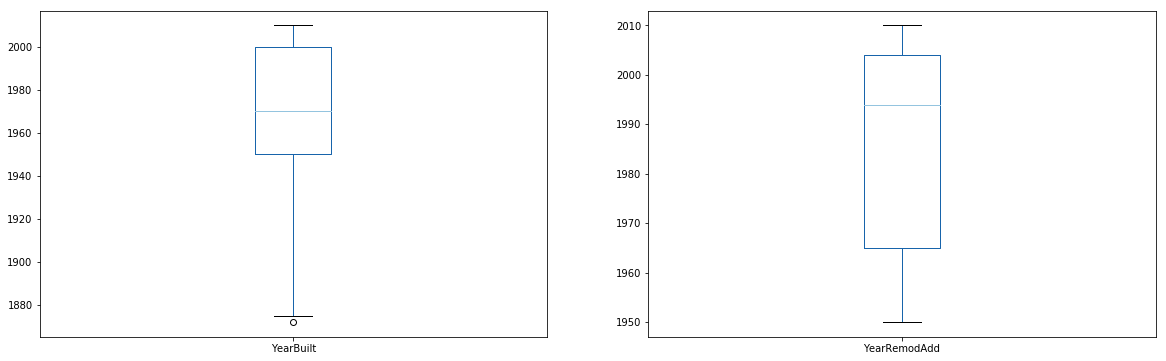

In [176]:
fig, axes=plt.subplots(1,2, figsize=(20,6))

plt.sca(axes[0])
df.YearBuilt.plot.box()

plt.sca(axes[1])
df.YearRemodAdd.plot.box()

## Part 1.13 - Trial  to find correlation. To recheck. Not finished yet.

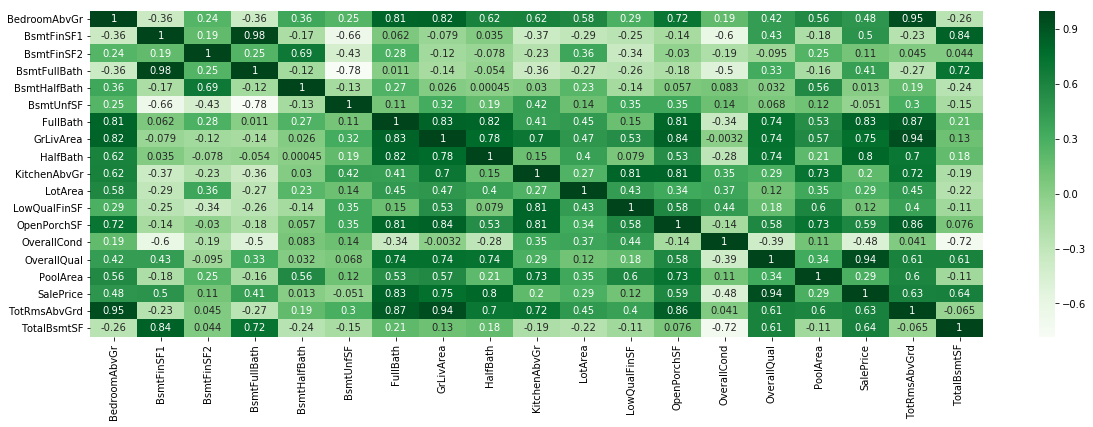

In [149]:
fig, ax =plt.subplots(1,1, figsize=(20,6))
sns.heatmap(new.corr(), cmap="Greens", annot=True)

Condition1
'Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRAn', 'PosA', 'RRNe',
       'RRNn'
LowQualFinSF
    			
Condition1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

## Part 1.14 - Trial  to find correlation Year, Zone, Venn. To recheck. Not finished yet.

In [167]:
Year_Price=df.groupby('YrSold')['SalePrice'].agg(np.mean)

In [168]:
Year_Price

YrSold
2006    188694.356589
2007    190527.892857
2008    178139.296443
2009    185613.482517
2010    184938.412587
Name: SalePrice, dtype: float64

In [171]:
# from matplotlib_venn import venn3

# set1 = set(Year_Price['2006'])
# set2 = set(Year_Price['2007'])
# set3 = set(Year_Price['2008'])

# venn3(subsets = [set1, set2, set3], set_labels = ('2008', '2009', '2010'))

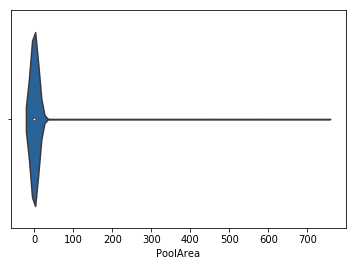

In [179]:
sns.violinplot('PoolArea', data=df)

In [181]:
df.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [180]:
df.PoolArea.max()

738

# Part 2 - Compute field relationship scores with the chosen statistical model.

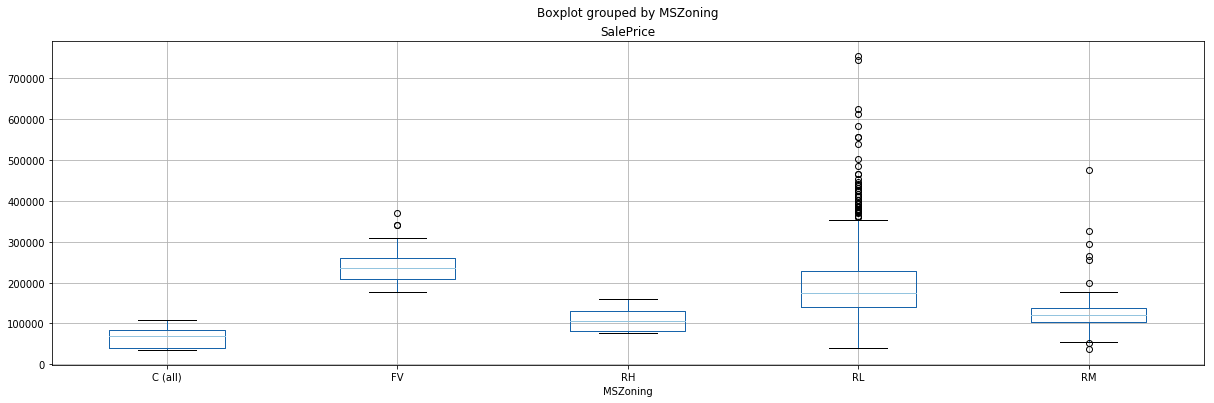

In [182]:
df.boxplot("SalePrice", by="MSZoning", figsize=(20,6))

In [185]:
df.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [195]:
model = ols('SalePrice ~ YrSold + C(OverallCond)+ C(MSSubClass)+ C(LotArea)+ C(MSZoning)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(OverallCond),4.730364e+10,8.0,4.518578,3.507297e-05
C(MSSubClass),8.209531e+10,10.0,6.273581,1.129264e-08
C(LotArea),5.565750e+12,919.0,4.628128,1.659976e-42
C(MSZoning),5.637774e+10,4.0,10.770722,3.925382e-08
YrSold,1.325372e+07,1.0,0.010128,9.199091e-01
Residual,3.650960e+11,279.0,NaN,NaN


In [196]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     6.472
Date:                Sat, 21 Sep 2019   Prob (F-statistic):           2.23e-58
Time:                        19:36:17   Log-Likelihood:                -13636.
No. Observations:                1220   AIC:                         2.915e+04
Df Residuals:                     279   BIC:                         3.396e+04
Df Model:                         940                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -2.308e+05   2.98e+06     -0.078      0.938   -6.09e+06    5.63e+06
C(OverallCond)[T.2]  -7.443e+04    3.3e+05     -0.226      0.822   -7.24e+05    5.75e+05
C(OverallCond)[T.3]  -5.968e+04   3.32e+05     -0.180      0.857   -7.13e+05    5.94e+05
C(OverallCond)[T.4]  -2.103e+04   3.31e+05     -0.064      0.949   -6.72e+05     6.3e+05
C(OverallCond)[T.5]  -1835.8449   3.31e+05     -0.006      0.996   -6.53e+05     6.5e+05
C(OverallCond)[T.6]  -1.797e+04   3.31e+05     -0.054      0.957    -6.7e+05    6.34e+05
C(OverallCond)[T.7]    539.8204   3.31e+05      0.002      0.999   -6.51e+05    6.53e+05
C(OverallCond)[T.8]  -1.118e+04   3.31e+05     -0.034      0.973   -6.63e+05    6.41e+05
C(OverallCond)[T.9]   1.719e+04   3.33e+05      0.052      0.959   -6.37e+05    6.72e+05
C(MSSubClass)[T.30]  -3.861e+04   1.01e+04     -3.835      0.000   -5.84e+04   -1.88e+04
C(MSSubClass)[T.40]  -2.756e+04      3e+04     -0.919      0.359   -8.66e+04    3.15e+04
C(MSSubClass)[T.45]  -8679.6672   1.73e+04     -0.501      0.617   -4.28e+04    2.54e+04
C(MSSubClass)[T.50]  -6495.7299   7391.375     -0.879      0.380    -2.1e+04    8054.215
C(MSSubClass)[T.60]   4.103e+04   6560.070      6.254      0.000    2.81e+04    5.39e+04
C(MSSubClass)[T.70]   1.023e+04   1.07e+04      0.952      0.342   -1.09e+04    3.14e+04
C(MSSubClass)[T.75]  -7571.1503   1.82e+04     -0.415      0.678   -4.35e+04    2.83e+04
C(MSSubClass)[T.80]   9171.6884   1.26e+04      0.731      0.466   -1.55e+04    3.39e+04
C(MSSubClass)[T.85]  -2536.0772   1.87e+04     -0.135      0.892   -3.94e+04    3.44e+04
C(MSSubClass)[T.120]  3.963e+04   3.31e+04      1.197      0.232   -2.55e+04    1.05e+05
C(LotArea)[T.2887]   -2.668e+04   3.15e+04     -0.846      0.398   -8.88e+04    3.54e+04
C(LotArea)[T.3182]    -155.9447    5.3e+04     -0.003      0.998   -1.04e+05    1.04e+05
C(LotArea)[T.3378]   -5.079e+04   5.25e+04     -0.967      0.334   -1.54e+05    5.26e+04
C(LotArea)[T.3500]   -3.999e+04    5.3e+04     -0.755      0.451   -1.44e+05    6.43e+04
C(LotArea)[T.3600]   -5.172e+04   5.22e+04     -0.990      0.323   -1.55e+05    5.11e+04
C(LotArea)[T.3636]   -4.114e+04    5.4e+04     -0.762      0.447   -1.47e+05    6.52e+04
C(LotArea)[T.3880]    -2.37e+04    5.6e+04     -0.423      0.672   -1.34e+05    8.65e+04
C(LotArea)[T.3950]   -2.327e+04   5.23e+04     -0.445      0.657   -1.26e+05    7.97e+04
C(LotArea)[T.4060]   -1.236e+04   5.33e+04     -0.232      0.817   -1.17e+05    9.26e+04
C(LotArea)[T.4118]   -4.331e+04   5.42e+04     -0.799      0.425    -1.5e+05    6.34e+04
C(LotArea)[T.4130]   -5.331e+04    5.4e+04     -0.988      0.324    -1.6e+05    5.29e+04
C(LotArea)[T.4270]    1.623e+04   5.83e+04      0.278      0.781   -9.86e+04    1.31e+05
C(LotArea)[T.4280]   -1.479e+04   5.41e+04     -0.274    

In [210]:
# X = df[['MSZoning']] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
# Y = df['MSSubClass']

# X = sm.add_constant(X) # adding a constant

# model = sm.OLS(Y, X).fit()
# predictions = model.predict(X) 

# print_model = model.summary()
# print(print_model)

In [212]:
# stats.f_oneway(*df['OverallCond'])

In [207]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = df.select_dtypes(include=numerics)

In [208]:
newdf

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,8450,7,5,2003,2003,706,0,150,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,9600,6,8,1976,1976,978,0,284,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,11250,7,5,2001,2002,486,0,434,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,9550,7,5,1915,1970,216,0,540,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,14260,8,5,2000,2000,655,0,490,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,7917,6,5,1999,2000,0,0,953,...,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,13175,6,6,1978,1988,790,163,589,...,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,9042,7,9,1941,2006,275,0,877,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,9717,5,6,1950,1996,49,1029,0,...,366,0,112,0,0,0,0,4,2010,142125


In [209]:
stats.ttest_rel(df['OverallCond'],df['SalePrice'], axis=0)

Ttest_relResult(statistic=-78.50407278429752, pvalue=0.0)